# Logging, Tracking, and Debugging Prompts using Comet

In this section, we will demonstrate how to log, track, and debug prompt using the `comet-llm` library. `comet-llm` is an open-sourced repo managed by Comet. Please give the repo star if you have a chance and submit any feedback you have! https://github.com/comet-ml/comet-llm

Let's first load all the necessary libraries:


In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', '')))

In [2]:
import IPython
import json
import tqdm
import pandas as pd
import numpy as np
import comet_llm
import urllib

from src.utils import setup_credentials, get_completion

In [3]:
setup_credentials()

The function below helps to generate the final results from the model after calling the OpenAI API:

### Load the Data

The code below loads both the few-shot demonstrations and the validation dataset used for testing the model.

In [4]:
# print markdown
def print_markdown(text):
    """Prints text as markdown"""
    IPython.display.display(IPython.display.Markdown(text))

# load validation data from GitHub
f = urllib.request.urlopen("https://raw.githubusercontent.com/comet-ml/comet-llmops/main/data/article-tags.json")
val_data = json.load(f)

# load few shot data from GitHub
f = urllib.request.urlopen("https://raw.githubusercontent.com/comet-ml/comet-llmops/main/data/few_shot.json")
few_shot_data = json.load(f)

The following is a helper function to obtain the final predictions from the model given a prompt template (e.g., zero-shot or few-shot) and the provided input data.

In [ ]:
def get_predictions(prompt_template, inputs):

    responses = []

    for i in tqdm(range(len(inputs))):
        message = prompt_template.format(input=inputs[i])
        response = get_completion(message)
        responses.append(response)

    return responses

### Zero-Shot Template

The code below defines the zero-shot template. Note that we use the same instruction from the few-shot prompt template. But in this case, we don't use the demonstrations.

In [7]:
zero_shot_template = """
Your task is to extract model names from machine learning paper abstracts. 
If you don't find any model name in the abstract or you are not sure, return ['NA'].
Do not include any marker, for example /n or ```json```, neither programming sintaxe in the response, only the list with model names.

Abstract: {input}
Tags:
"""

### Few-Shot Template

First, we define a few-shot template which will leverage the few-shot demonstration data loaded previously.

In [6]:
# function to define the few-shot template
def get_few_shot_template(few_shot_prefix, few_shot_suffix, few_shot_examples):
    return few_shot_prefix + "\n\n" + "\n".join([ "Abstract: "+ ex["abstract"] + "\n" + "Tags: " + str(ex["tags"]) + "\n" for ex in few_shot_examples]) + "\n\n" + few_shot_suffix

# function to sample few shot data
def random_sample_data (data, n):
    return np.random.choice(few_shot_data, n, replace=False)


# the few-shot prefix and suffix
few_shot_prefix = """
Your task is to extract model names from machine learning paper abstracts. 
Your response should be one list of strings with the all model names presented in the paper abstract.
For example, if two models are mentioned in the text, your response should be in the format ['model_name_1', 'model_name_2'].
Do not include models names that are not mentioned in the text.
If you don't find any model name in the abstract or you are not sure, return ['NA'].
Do not include any marker, for example /n or, neither programming sintaxe in the response, only the list with model names.

Consider the following abstracts and its respective tags as expected responses:
"""

few_shot_suffix = """
Abstract: {input}
Tags:
"""

# load 3 samples from few shot data
few_shot_template = get_few_shot_template(few_shot_prefix, few_shot_suffix, random_sample_data(few_shot_data, 3))

### Get Predictions

We then generated all the predictions using the validation data as inputs:

In [8]:
# get abstracts and expected tags from validation data
abstracts = [val_data[i]["abstract"] for i in range(len(val_data))]
expected_tags = [str(val_data[i]["tags"]) for i in range(len(val_data))]

In [9]:
# get the predictions for the few-shot template
few_shot_predictions = get_predictions(few_shot_template, abstracts)

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


In [12]:
# get the predictions for the zero-shot template
zero_shot_predictions = get_predictions(zero_shot_template, abstracts)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [19]:
few_shot_predictions = [i.replace("\n", "") for i in few_shot_predictions]
zero_shot_predictions = [i.replace("\n", "") for i in zero_shot_predictions]

In [ ]:
print("Zero shot predictions")
print(zero_shot_predictions)
print("\nFew shot predictions")
print(few_shot_predictions)
print("\nExpected tags")
print(expected_tags)

Few shot predictions
["['LLaMA', 'WizardLM', 'OpenAI ChatGPT']\n", "['FLAN-T5']\n", "['NA']\n", "['NA']\n", "['ChatGPT']\n", "['ViT', 'OpenCLIP']\n", "['SAM', 'Stable Diffusion', 'Inpaint Anything (IA)']\n", "['Anything-3D', 'BLIP', 'Segment-Anything']\n", "['Chameleon', 'GPT-4', 'ChatGPT']\n", "['NA']\n"]


Zero shot predictions
["['LLaMA', 'WizardLM', 'OpenAI ChatGPT']\n", "['FLAN-T5', 'LoRA']\n", "['NA']\n", "['PAXQA']\n", "['ChatGPT']\n", "['ViT', 'OpenCLIP']\n", "['Segment-Anything Model (SAM)', 'Inpaint Anything (IA)', 'Stable Diffusion']\n", "['Anything-3D', 'BLIP', 'Segment-Anything']\n", "['Chameleon', 'GPT-4', 'ChatGPT']\n", "['NA']\n"]


Expected tags
["['LLaMA', 'ChatGPT', 'WizardLM']", "['FLAN-T5', 'FLAN']", "['NA']", "['PAXQA']", "['ChatGPT']", "['OpenCLIP', 'ViT']", "['SAM', 'IA']", "['Anything-3D', 'BLIP', 'Segment-Anything']", "['Chameleon', 'GPT-4', 'ChatGPT']", "['NA']"]


### Evaluation of model precision

In [15]:
precision_template = """
YOU ARE AN EXPERT EVALUATOR SPECIALIZED IN ASSESSING THE "CONTEXT PRECISION" METRIC FOR LLM GENERATED OUTPUTS.
YOUR TASK IS TO EVALUATE HOW PRECISELY A GIVEN ANSWER FROM AN LLM FITS THE EXPECTED ANSWER, GIVEN THE CONTEXT AND USER INPUT.

###INSTRUCTIONS###

1. **EVALUATE THE CONTEXT PRECISION:**
    - **ANALYZE** the provided user input, expected answer, answer from another LLM, and the context.
    - **COMPARE** the answer from the other LLM with the expected answer, focusing on how well it aligns in terms of context, relevance, and accuracy.
    - **ASSIGN A SCORE** from 0.0 to 1.0 based on the following scale:

###SCALE FOR CONTEXT PRECISION METRIC (0.0 - 1.0)###

- **0.0:** COMPLETELY INACCURATE - The LLM's answer is entirely off-topic, irrelevant, or incorrect based on the context and expected answer.
- **0.2:** MOSTLY INACCURATE - The answer contains significant errors, misunderstanding of the context, or is largely irrelevant.
- **0.4:** PARTIALLY ACCURATE - Some correct elements are present, but the answer is incomplete or partially misaligned with the context and expected answer.
- **0.6:** MOSTLY ACCURATE - The answer is generally correct and relevant but may contain minor errors or lack complete precision in aligning with the expected answer.
- **0.8:** HIGHLY ACCURATE - The answer is very close to the expected answer, with only minor discrepancies that do not significantly impact the overall correctness.
- **1.0:** PERFECTLY ACCURATE - The LLM's answer matches the expected answer precisely, with full adherence to the context and no errors.

2. **PROVIDE A REASON FOR THE SCORE:**
    - **JUSTIFY** why the specific score was given, considering the alignment with context, accuracy, relevance, and completeness.

3. **RETURN THE RESULT IN A DICT FORMAT** with following keys:
        precision_score: The score between 0.0 and 1.0,
        explanation: A detailed explanation of why the score was assigned

###WHAT NOT TO DO###
- **DO NOT** assign a high score to answers that are off-topic or irrelevant, even if they contain some correct information.
- **DO NOT** give a low score to an answer that is nearly correct but has minor errors or omissions; instead, accurately reflect its alignment with the context.
- **DO NOT** omit the justification for the score; every score must be accompanied by a clear, reasoned explanation.
- **DO NOT** disregard the importance of context when evaluating the precision of the answer.
- **DO NOT** assign scores outside the 0.0 to 1.0 range.
- **DO NOT** return any output format other than one specified above.
- **DO NOT** include any marker, for example /n or ```json```, neither programming sintaxe in the response.

NOW, EVALUATE THE PROVIDED INPUTS AND CONTEXT TO DETERMINE THE CONTEXT PRECISION SCORE.

###INPUTS:###
***
Input:
{input}

Output:
{output}

Expected Output:
{expected_output}

Context:
{context}
***
"""

In [16]:
zero_shot_scores = []

for i in tqdm(range(len(abstracts))):

    prompt = precision_template.format(
        input=abstracts[i],
        output=zero_shot_predictions[i],
        expected_output=expected_tags[i],
        context=zero_shot_template,
    )
    response = get_completion(prompt)
    response_dict = json.loads(response)

    zero_shot_scores.append(response_dict)

100%|██████████| 10/10 [00:21<00:00,  2.20s/it]


In [18]:
zero_shot_scores

[{'precision_score': 0.8,
  'explanation': 'The LLM correctly identified all three model names mentioned in the abstract: LLaMA, WizardLM, and ChatGPT.  However, the order of the model names in the generated output differs from the expected output. While the content is highly accurate, the slight discrepancy in ordering reduces the score from a perfect 1.0 to 0.8. The context clearly requests model names, and the LLM fulfilled this request accurately, despite the minor ordering issue.'},
 {'precision_score': 0.6,
  'explanation': "The LLM's output ['FLAN-T5', 'LoRA'] is partially accurate.  While 'FLAN-T5' is correctly identified as a model name from the abstract, 'LoRA' is not a model name itself but rather a parameter-efficient fine-tuning technique used with the FLAN-T5 model. The expected output ['FLAN-T5', 'FLAN'] correctly identifies 'FLAN-T5' and also includes 'FLAN' which is part of the model's name.  The inclusion of LoRA shows a misunderstanding of the text, reducing the prec

In [20]:
few_shot_scores = []

for i in tqdm(range(len(abstracts))):

    prompt = precision_template.format(
        input=abstracts[i],
        output=few_shot_predictions[i],
        expected_output=expected_tags[i],
        context=few_shot_template,
    )
    response = get_completion(prompt)
    response_dict = json.loads(response)

    few_shot_scores.append(response_dict)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


In [21]:
few_shot_scores

[{'precision_score': 0.8,
  'explanation': 'The LLM\'s output is mostly accurate.  It correctly identifies all three models mentioned in the abstract: LLaMA, WizardLM, and ChatGPT. However, the order is slightly incorrect. The expected output specifies the order as [\'LLaMA\', \'ChatGPT\', \'WizardLM\'], while the LLM produced [\'LLaMA\', \'WizardLM\', \'OpenAI ChatGPT\'].  The difference is minor; the only issue is the order and the inclusion of "OpenAI" before ChatGPT, which is a minor stylistic variation. Given the instructions focused on extracting model names, the slight ordering discrepancy and the inclusion of "OpenAI" do not significantly detract from the overall accuracy. Therefore, a score of 0.8 reflects the high accuracy despite these minor imperfections.'},
 {'precision_score': 0.8,
  'explanation': "The LLM's answer, ['FLAN-T5'], is mostly accurate.  It correctly identifies 'FLAN-T5' as a model name mentioned in the abstract. However, it misses 'FLAN', which is also expli

## Tracking & Evaluate your LLM Application

Reference: https://www.comet.com/docs/opik/evaluation/evaluate_your_llm

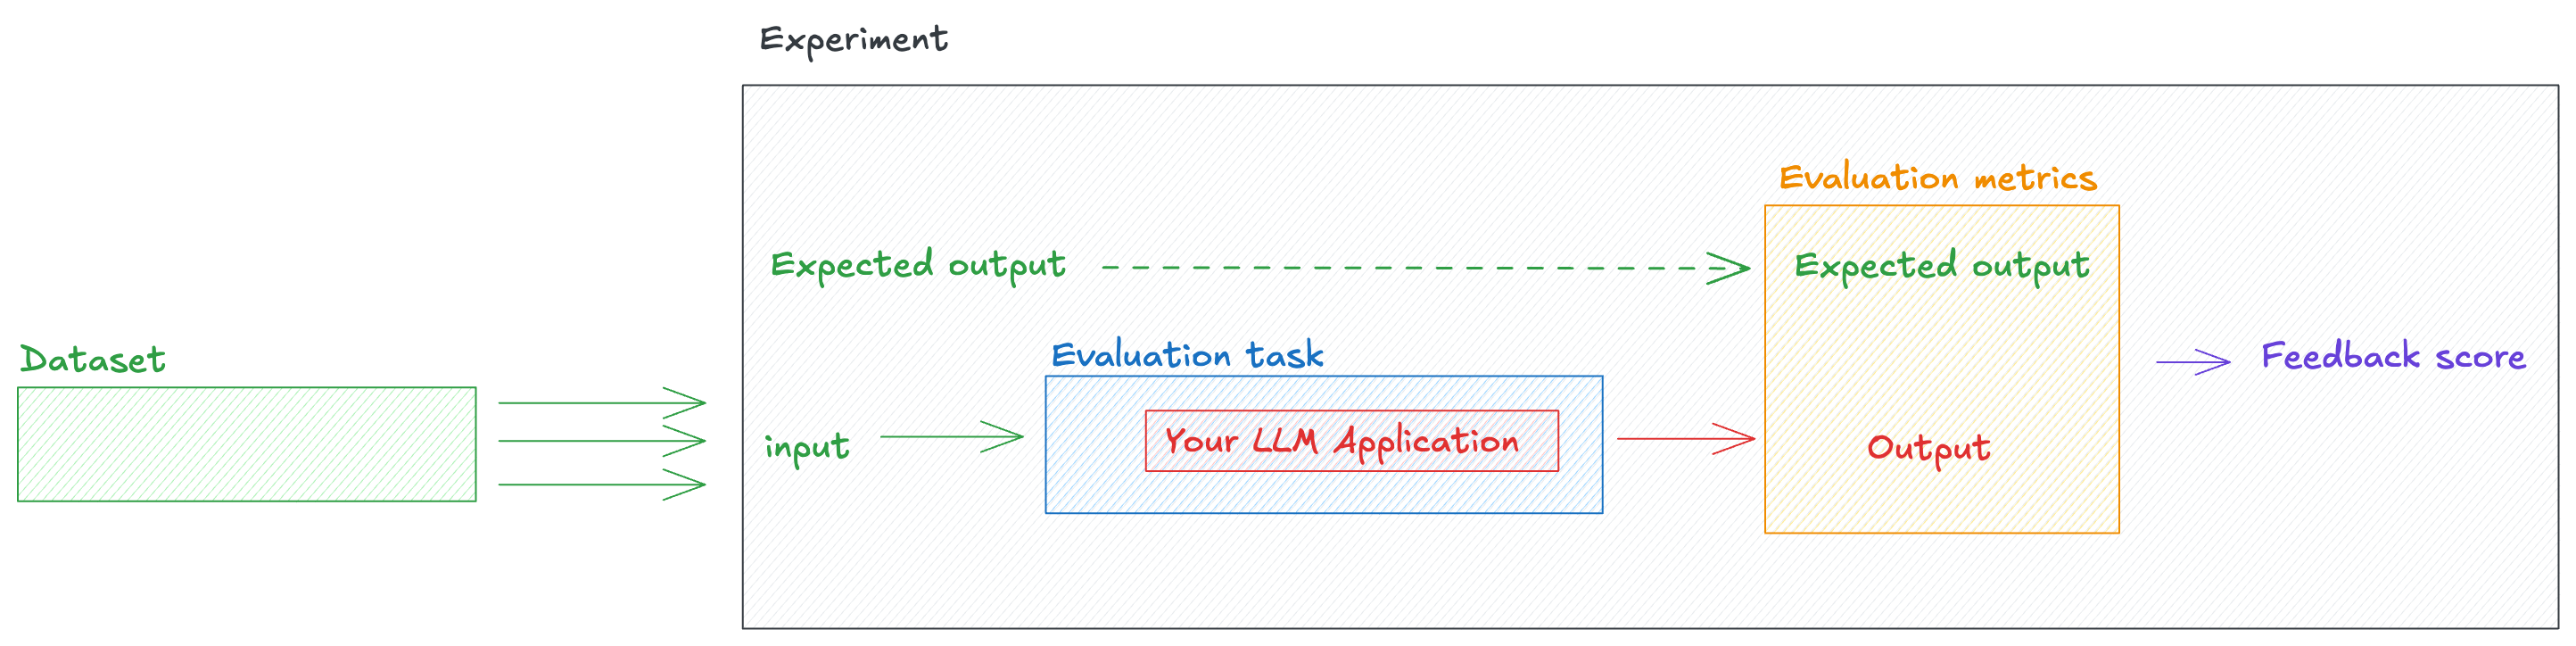

### 1. Manage Datasets

In [ ]:
from opik import Opik

In [ ]:
# Create a dataset
client = Opik()
dataset = client.get_or_create_dataset(name="machine-learning-papers")

In [25]:
dataset_list = []
for i in range(len(abstracts)):
    dataset_list.append({"input": abstracts[i], "expected_output": expected_tags[i]})

dataset.insert(dataset_list)

### 2. Add tracking to your LLM application

In [26]:
from opik import track

In [53]:
# This method is the LLM application that you want to evaluate
# Typically this is not updated when creating evaluations

@track
def zero_shot_get_prediction(input: str) -> str:


    prompt = zero_shot_template.format(input=input)
    response = get_completion(prompt)
    response = response.replace("\n", "")
    
    return response

@track
def zero_shot_context() -> str:
    return zero_shot_template

@track
def few_shot_get_prediction(input: str) -> str:

    prompt = few_shot_template.format(input=input)
    response = get_completion(prompt)
    response = response.replace("\n", "")
    
    return response

@track
def few_shot_context() -> str:
    return few_shot_template

### 3. Define the evaluation task

In [49]:
def evaluation_task_zero_shot(x):
    return {
        "input": x['input'],
        "output": zero_shot_get_prediction(x['input']),
        "expected_output": x['expected_output'],
        "context": zero_shot_context()
    }

def evaluation_task_few_shot(x):
    return{
        "input": x['input'],
        "output": few_shot_get_prediction(x['input']),
        "expected_output": x['expected_output'],
        "context": few_shot_context()
    }

### 4. Define the evaluation metric

Reference: https://www.comet.com/docs/opik/evaluation/metrics/custom_metric

In [51]:
from opik.evaluation.metrics import base_metric, score_result
from typing import Any

In [ ]:
class PrecisionMetric(base_metric.BaseMetric):
    def __init__(self, name: str = "precision", model_name: str = "gemini-1.5-flash"):
        self.name = name
        self.model_name = model_name
        self.prompt_template = precision_template

    def score(self, input: str, output: str, expected_output: str, context: str, **ignored_kwargs: Any):
        """
        Score the output of an LLM.

        Args:
            output: The output of an LLM to score.
            **ignored_kwargs: Any additional keyword arguments. This is important so that the metric can be used in the `evaluate` function.
        """
        # Construct the prompt based on the output of the LLM
        prompt = self.prompt_template.format(
            input=input,
            output=output,
            expected_output=expected_output,
            context=context,
        )

        # Generate and parse the response from the LLM
        response = get_completion(prompt)
        response_dict = json.loads(response)

        return score_result.ScoreResult(
            name=self.name,
            value=float(response_dict['precision_score']),
            reason=str(response_dict['explanation']),
        )

### 4. Run the evaluation

In [31]:
from opik.evaluation import evaluate

In [32]:
MODEL = "gemini-1.5-flash"

In [46]:
precision_score = PrecisionMetric()

In [ ]:
evaluation = evaluate(
    project_name="machine-learning-papers",
    experiment_name="zero-shot-llm-evaluation",
    dataset=dataset,
    task=evaluation_task_zero_shot,
    scoring_metrics=[precision_score],
    experiment_config={
        "model": MODEL,
    },
)


OPIK: Started logging traces to the "machine-learning-papers" project at https://www.comet.com/opik/llmops-udacity/redirect/projects?name=machine-learning-papers.

Evaluation:   0%|          | 0/4 [19:26<?, ?it/s]



Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
OPIK: Failed to compute metric precision. Score result will be marked as failed.
Traceback (most recent call last):
  File "/home/anderson/Documents/Data-Science/LLM Courses/LLMOps-Udacity/venv/lib/python3.9/site-packages/opik/evaluation/tasks_scorer.py", line 29, in _score_test_case
    result = metric.score(**score_kwargs)
  File "/tmp/ipykernel_170493/387139343.py", line 30, in score
    response = ge

╭─ machine-learning-papers (10 samples) ─╮
│                                        │
│ Total time:        00:00:21            │
│ Number of samples: 10                  │
│                                        │
│ precision: 0.9000 (avg) - 2 failed     │
│                                        │
╰────────────────────────────────────────╯

Uploading results to Opik ...

View the results ]8;id=217894;https://www.comet.com/opik/llmops-udacity/experiments/01933b10-f526-7ac4-8e4d-ade7b3da5fb1/compare?experiments=%5B%220673a745-b0b1-7c8d-8000-7cb05f1373da%22%5D\in your Opik dashboard]8;;\.

In [54]:
evaluation = evaluate(
    project_name="machine-learning-papers",
    experiment_name="few-shot-llm-evaluation",
    dataset=dataset,
    task=evaluation_task_few_shot,
    scoring_metrics=[precision_score],
    experiment_config={
        "model": MODEL,
    },
)


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..




OPIK: Failed to compute metric precision. Score result will be marked as failed.
Traceback (most recent call last):
  File "/home/anderson/Documents/Data-Science/LLM Courses/LLMOps-Udacity/venv/lib/python3.9/site-packages/opik/evaluation/tasks_scorer.py", line 29, in _score_test_case
    result = metric.score(**score_kwargs)
  File "/tmp/ipykernel_170493/387139343.py", line 30, in score
    response = get_completion(prompt)
  File

╭─ machine-learning-papers (10 samples) ─╮
│                                        │
│ Total time:        00:00:07            │
│ Number of samples: 10                  │
│                                        │
│ precision: 0.8250 (avg) - 2 failed     │
│                                        │
╰────────────────────────────────────────╯

Uploading results to Opik ...

View the results ]8;id=312333;https://www.comet.com/opik/llmops-udacity/experiments/01933b10-f526-7ac4-8e4d-ade7b3da5fb1/compare?experiments=%5B%220673a772-d8de-75e0-8000-e7e209cfee3d%22%5D\in your Opik dashboard]8;;\.